# IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

# FUNCTIONS

Feature Creation

In [2]:
def create_features_fulldata(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [3]:
def get_value_at_day(series, day):
    if day in series.index:
        return series[day]
    return series.reindex(index=[day], method='nearest')[0]

In [4]:
def create_features_product(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['dayofmonth'] = df.index.day
    df['lag_1'] = df['sale'].shift(1)
    df['lag_7'] = df['sale'].shift(6)
    df['last_week_sale'] = [get_value_at_day(df['sale'], day - pd.DateOffset(days=7)) for day in df.index]
    df['last_month_sale'] = [get_value_at_day(df['sale'], day - pd.DateOffset(months=1)) for day in df.index]
    return df

Train Test Split

In [5]:
def train_test_split_time_series(data, test_size):
    """
    Split a time series dataset into train and test sets.

    Parameters:
    - data: The time series dataset to be split.
    - test_size: The proportion of the dataset to include in the test set.

    Returns:
    - train_data: The training data.
    - test_data: The testing data.
    """

    num_samples = len(data)
    split_index = int(num_samples * (1 - test_size))

    train_data = data[:split_index]
    test_data = data[split_index:]

    return train_data, test_data

MODEL FUNCTION

In [6]:
def predict(df,product_id):
    global all_forecasts_df
    # data processing
    df = df[['date','sale']]
    df['date'] = pd.to_datetime(df['date'])
    df = df.groupby('date').sum().reset_index()
        df = df.set_index('date')
    
    # outlier removal
    median = df['sale'].median()
    mad = np.median(np.abs(df['sale'] - median))
    outlier_threshold = 1.75
    outliers = df[abs(df['sale'] - median) > outlier_threshold * mad]
    df = df[~df.index.isin(outliers.index)]
    
    # feature creation
    df = create_features_product(df)  
    FEATURES = ['month','dayofweek', 'dayofmonth','lag_1','lag_7','last_week_sale','last_month_sale']
    TARGET = 'sale'
    
    X_all = df[FEATURES]
    y_all = df[TARGET]
    
    # model
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.14)
    reg.fit(X_all, y_all,
            eval_set=[(X_all, y_all)],
            verbose=False)
    # Create future dataframe
    future = pd.date_range('2023-08-01','2023-12-31')
    future = future[future.weekday != 6]
    future_df = pd.DataFrame(index=future)
    future_df['isFuture'] = True
    df['isFuture'] = False
    df_and_future = pd.concat([df, future_df])
    df_and_future = create_features_product(df_and_future)
    future_w_features = df_and_future.query('isFuture').copy()
    
    #future prediction
    future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
    
    forecasts_df = pd.DataFrame({'forecasted_sales': future_w_features['pred']}, index=future_w_features.index)
    
    all_forecasts_df = pd.concat([all_forecasts_df, forecasts_df])
    

# DATASET

In [7]:
dataset = pd.read_csv("HUL_BRIT_HMR.csv")
dataset.rename(columns = {'bill_date':'date', 'net_amount':'sale'}, inplace = True)
dataset['product_name'] = dataset['product_name'].str.rstrip()
dataset['date'] = pd.to_datetime(dataset['date'])

In [8]:
df_daily_data_all = dataset[['date','sale']]

In [9]:
df_daily_data_all = df_daily_data_all.groupby('date').sum().reset_index()

In [10]:
df_daily_data_all = df_daily_data_all.drop(df_daily_data_all[df_daily_data_all.date < '2023-01-01'].index)

In [11]:
df_daily_data_all = df_daily_data_all.set_index('date')

# EDA

Basic Visualization

In [12]:
print(df_daily_data_all['sale'].describe())

count    1.660000e+02
mean     2.835324e+06
std      7.873990e+05
min      1.397896e+06
25%      2.224930e+06
50%      2.661110e+06
75%      3.293589e+06
max      6.887114e+06
Name: sale, dtype: float64


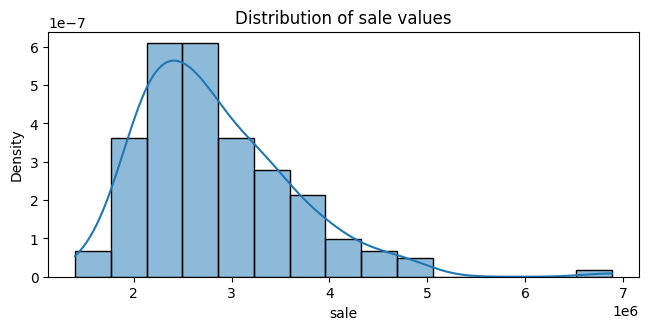

In [13]:
plt.figure(figsize=(16,7))
plt.subplot(2,2,1)
sns.histplot(df_daily_data_all['sale'],kde=True,stat="density")
plt.title('Distribution of sale values')


plt.subplots_adjust(wspace=0.1)

In [14]:
df_daily_data_all = create_features_fulldata(df_daily_data_all)

Text(0, 0.5, 'Sales')

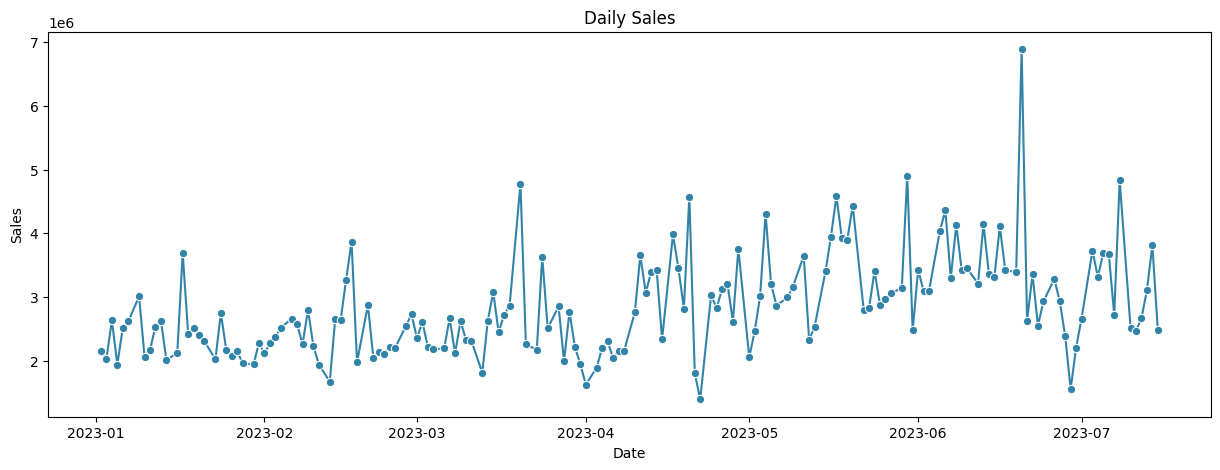

In [15]:
plt.figure(figsize=(15,5))
sns.lineplot(x='date', y='sale', data=df_daily_data_all, marker='o', color='#3283a8')
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')

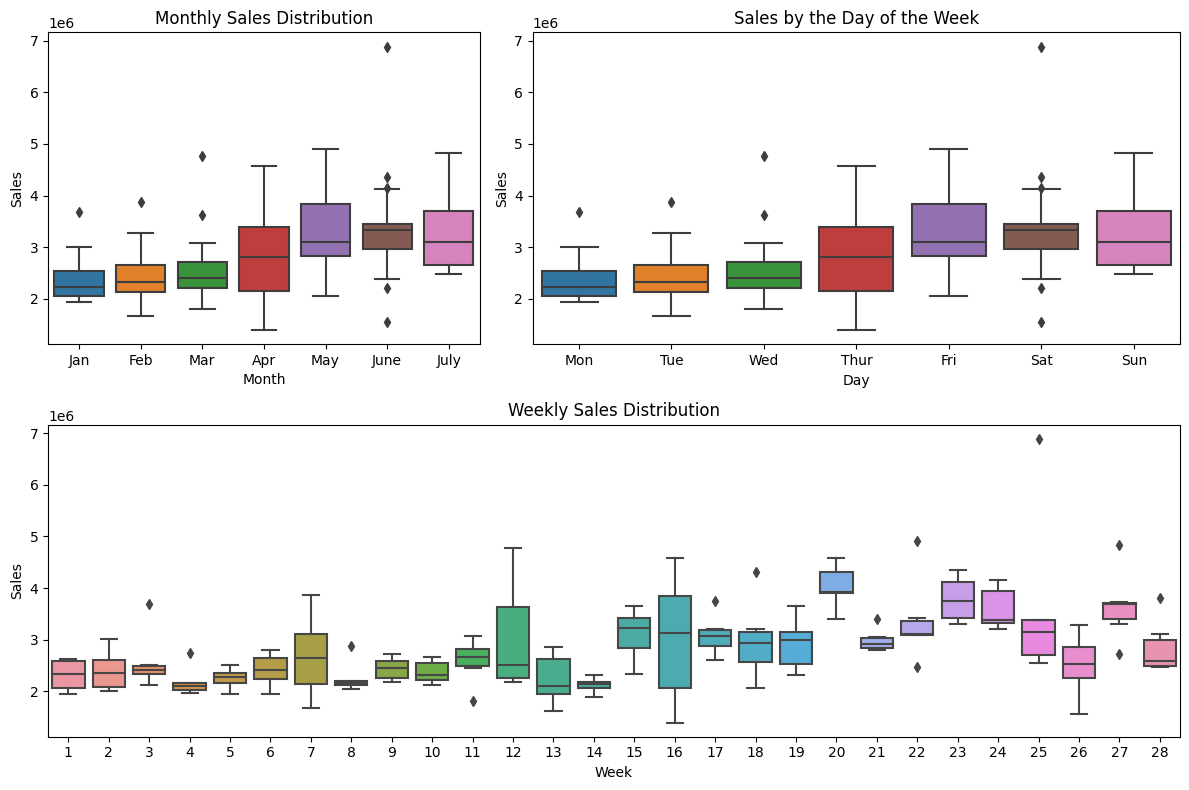

In [16]:
plt.figure(figsize=(12, 8))

gs = gridspec.GridSpec(2, 2, width_ratios=[2, 3])

# First subplot: Sales distribution by month

ax1 = plt.subplot(gs[0, 0])
sns.boxplot(data=df_daily_data_all, x='month', y='sale', ax=ax1)
ax1.set_title('Monthly Sales Distribution')
ax1.set_xlabel('Month')
ax1.set_ylabel('Sales')
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July'])

# Third subplot: Sales by the day of the week
ax3 = plt.subplot(gs[0, 1])
sns.boxplot(data=df_daily_data_all, x='month', y='sale', ax=ax3)
ax3.set_title('Sales by the Day of the Week')
ax3.set_xlabel('Day')
ax3.set_ylabel('Sales')
ax3.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])

# Second subplot: Weekly Sales Distribution (bigger)
ax2 = plt.subplot(gs[1, :])
sns.boxplot(data=df_daily_data_all, x='weekofyear', y='sale', ax=ax2)
ax2.set_title('Weekly Sales Distribution')
ax2.set_xlabel('Week')
ax2.set_ylabel('Sales')

plt.tight_layout()
plt.show()

Trend Analysis

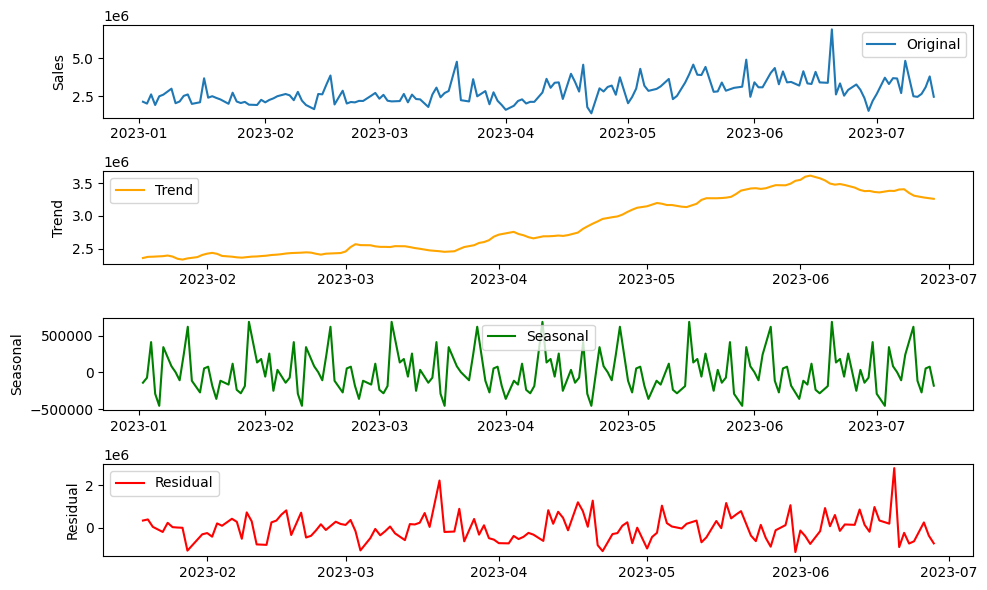

In [17]:
plt.figure(figsize=(10, 6))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(df_daily_data_all.index, df_daily_data_all['sale'], label='Original')
plt.legend()
plt.ylabel('Sales')

result = seasonal_decompose(df_daily_data_all['sale'], model='additive', period=30)

# Trend component
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend', color='orange')
plt.legend()
plt.ylabel('Trend')

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.legend()
plt.ylabel('Seasonal')

# Residual component
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual', color='red')
plt.legend()
plt.ylabel('Residual')

plt.tight_layout()
plt.show()

# TESTING FOR SINGLE PRODUCT

Fetching relevant data

In [18]:
df_product_daily = dataset[dataset['product_name']=='LB GERM GUARD SOAP 42G']

In [19]:
df_product_daily = df_product_daily[['date','sale']]

In [20]:
df_product_daily['date'] = pd.to_datetime(df_product_daily['date'])
df_product_daily = df_product_daily.groupby('date').sum().reset_index()

In [21]:
df_product_daily = df_product_daily.set_index('date')

Visualisation

Text(0, 0.5, 'Sales')

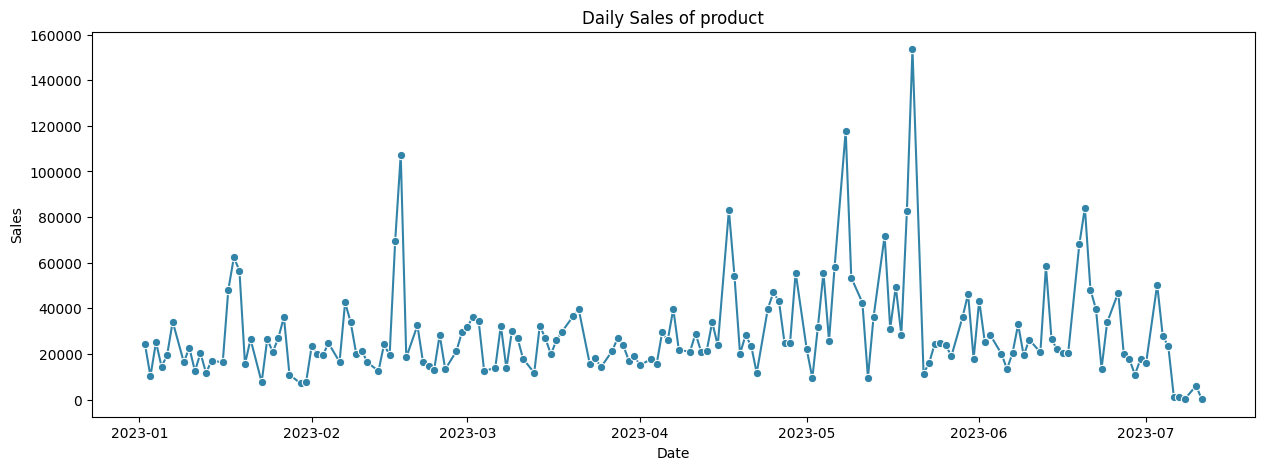

In [22]:
plt.figure(figsize=(15,5))
sns.lineplot(x='date', y='sale', data=df_product_daily, marker='o', color='#3283a8')
plt.title('Daily Sales of product')
plt.xlabel('Date')
plt.ylabel('Sales')

In [23]:
print(df_product_daily.describe())

                sale
count     162.000000
mean    28876.423765
std     20896.974059
min       138.890000
25%     17099.302500
50%     23724.370000
75%     33849.017500
max    153564.450000


<Axes: title={'center': 'Distribution of sales'}, xlabel='sale', ylabel='Density'>

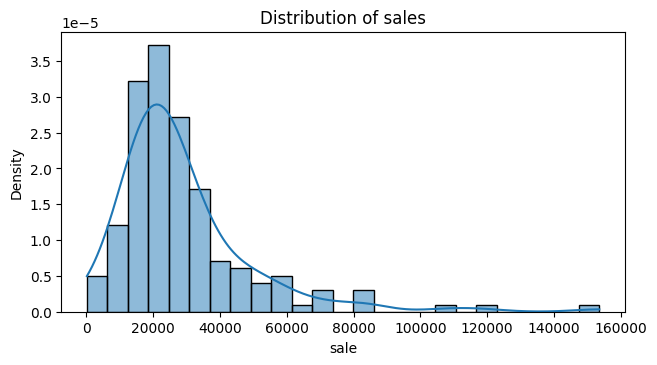

In [24]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.title('Distribution of sales')
sns.histplot(df_product_daily['sale'],kde=True,stat="density")

Outlier Handling

In [25]:
median = df_product_daily['sale'].median()
mad = np.median(np.abs(df_product_daily['sale'] - median))
outlier_threshold = 1.75
outliers = df_product_daily[abs(df_product_daily['sale'] - median) > outlier_threshold * mad]
df_product_daily_wo_outliers = df_product_daily[~df_product_daily.index.isin(outliers.index)]

Text(0.5, 0.98, 'Distribution of sales after outlier handling')

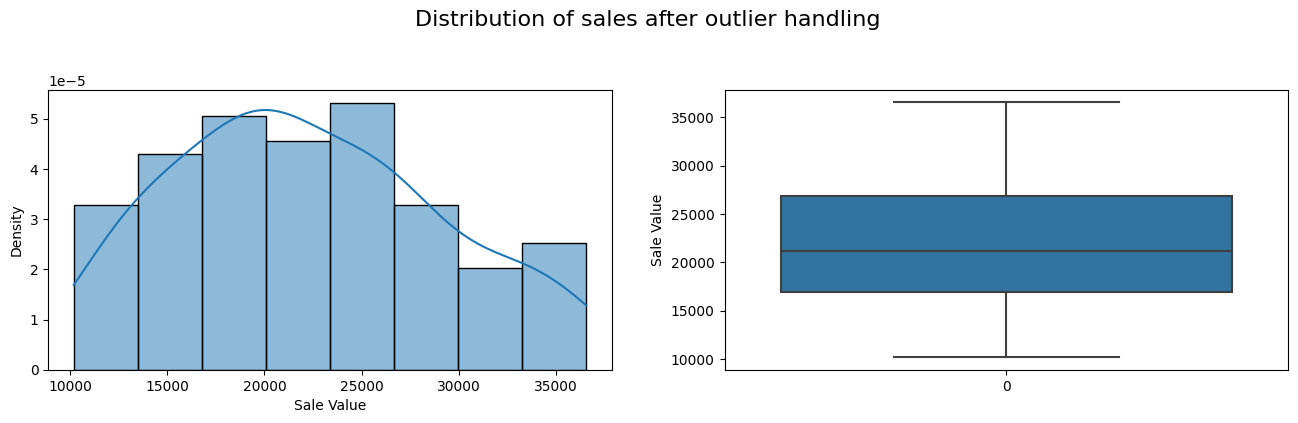

In [26]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(df_product_daily_wo_outliers['sale'],kde=True,stat="density")
plt.xlabel('Sale Value')  
plt.ylabel('Density')  

plt.subplot(2,2,2)
sns.boxplot(df_product_daily_wo_outliers['sale'])
plt.ylabel('Sale Value')
plt.suptitle('Distribution of sales after outlier handling', fontsize=16)


Train Test Split

In [27]:
train, test = train_test_split_time_series(df_product_daily_wo_outliers,0.25)

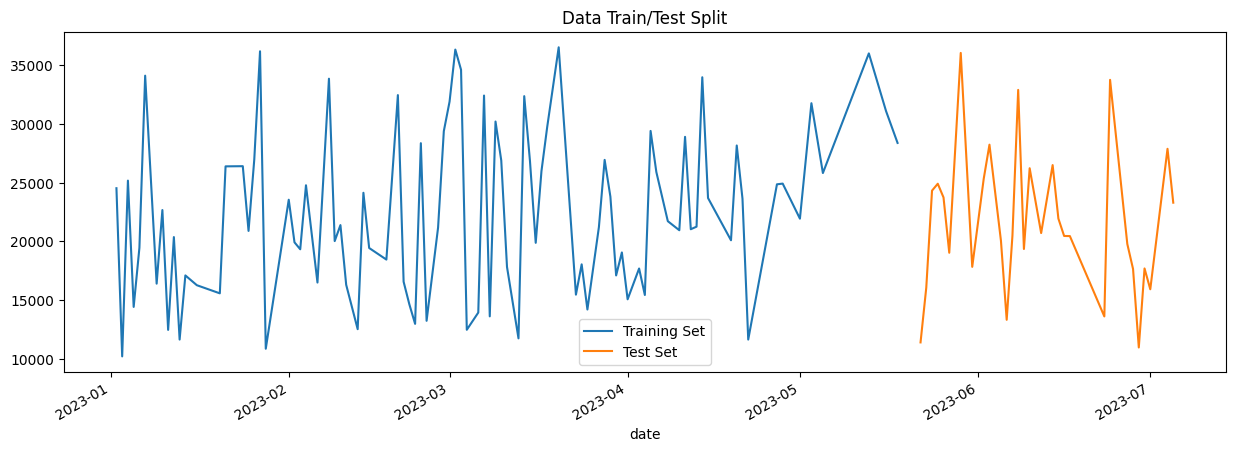

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

Feature Engineering

In [29]:
df_product_daily_wo_outliers = create_features_product(df_product_daily_wo_outliers)

In [30]:
train = create_features_product(train)
test = create_features_product(test)

FEATURES = ['month','dayofweek', 'dayofmonth','lag_1','lag_7','last_week_sale','last_month_sale']
TARGET = 'sale'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [60]:
train.head(10)

,sale,month,dayofweek,dayofmonth,lag_1,lag_7,last_week_sale,last_month_sale
date,,,,,,,,
2023-01-02,24534.98,1,0,2,NaN,NaN,24534.98,24534.98
2023-01-03,10194.64,1,1,3,24534.98,NaN,24534.98,24534.98
2023-01-04,25183.11,1,2,4,10194.64,NaN,24534.98,24534.98
2023-01-05,14413.24,1,3,5,25183.11,NaN,24534.98,24534.98
2023-01-06,19458.91,1,4,6,14413.24,NaN,24534.98,24534.98
2023-01-07,34132.15,1,5,7,19458.91,NaN,24534.98,24534.98
2023-01-09,16396.97,1,0,9,34132.15,24534.98,24534.98,24534.98
2023-01-10,22673.80,1,1,10,16396.97,10194.64,10194.64,24534.98
2023-01-11,12453.92,1,2,11,22673.80,25183.11,25183.11,24534.98


Feature Correlation

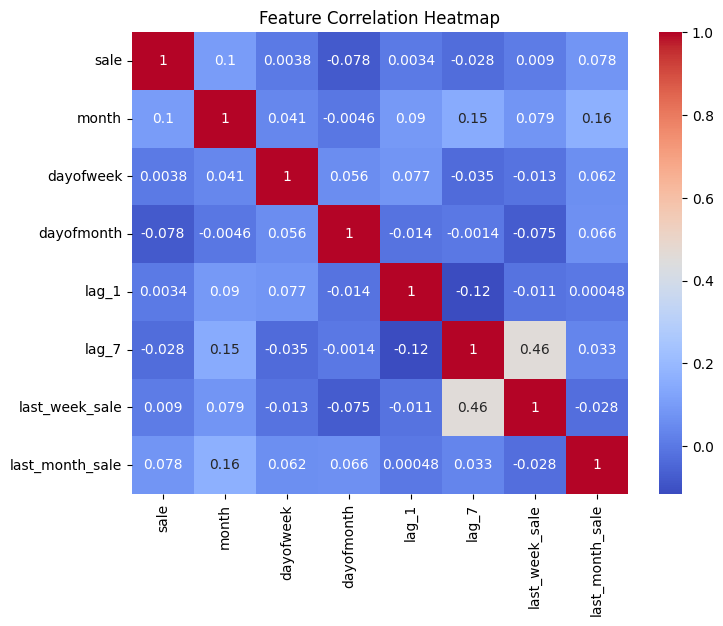

In [31]:
correlation_matrix = df_product_daily_wo_outliers.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

Model Creation and Testing

In [32]:
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.14)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:20577.58408	validation_1-rmse:19550.86327
[69]	validation_0-rmse:1737.78858	validation_1-rmse:6836.35685


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.14, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

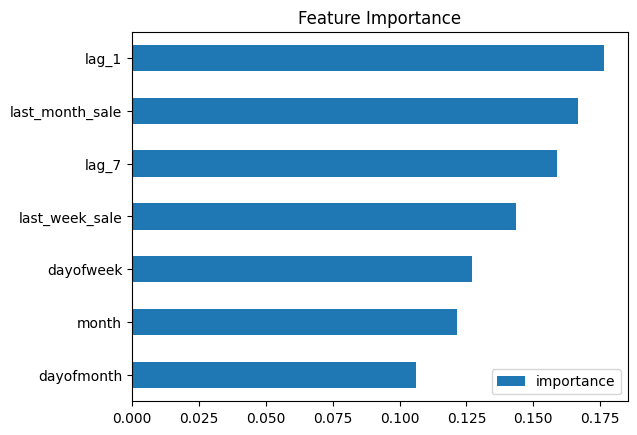

In [33]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [34]:
test['prediction'] = model.predict(X_test)

In [35]:
df_product_daily_wo_outliers = df_product_daily_wo_outliers.merge(test['prediction'], how='left', left_index=True, right_index=True)

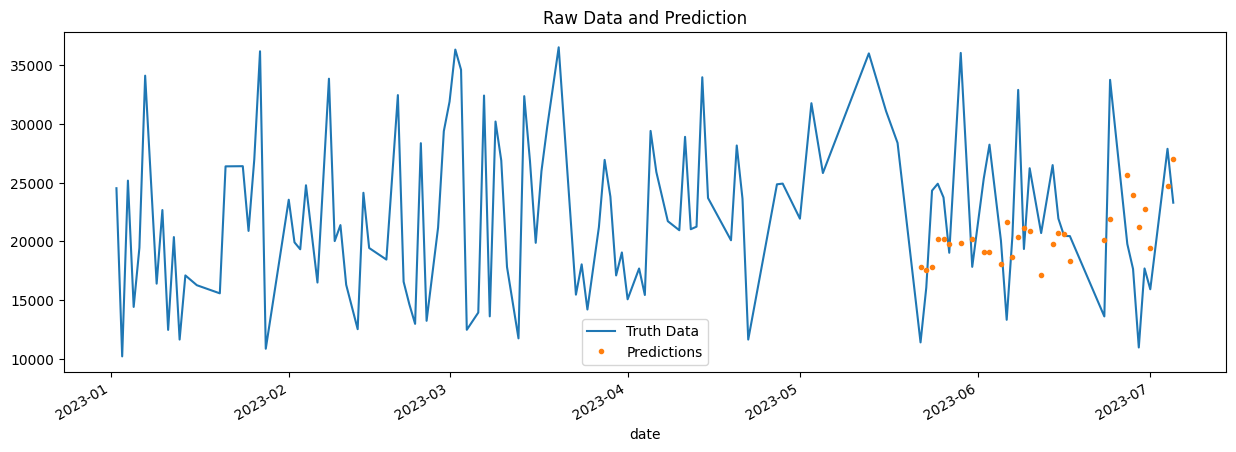

In [36]:
ax = df_product_daily_wo_outliers[['sale']].plot(figsize=(15, 5))
df_product_daily_wo_outliers['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [37]:
print('Root Mean Square Error: ',np.sqrt(mean_squared_error(y_test, test['prediction'])))

Root Mean Square Error:  6498.109410569575


In [38]:
absolute_percentage_errors = np.abs((y_test - test['prediction']) / y_test) * 100
average_percentage_error = np.mean(absolute_percentage_errors)

print("Average Percentage Error:", average_percentage_error)

Average Percentage Error: 25.835794804082813


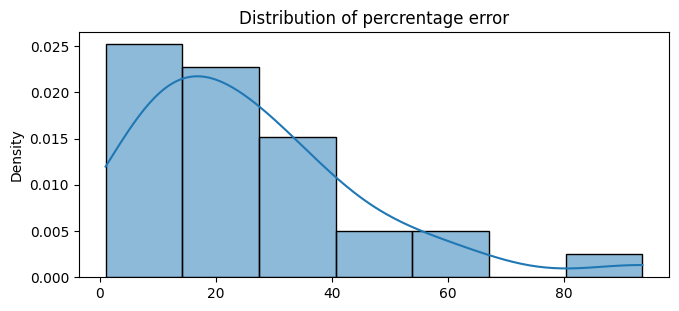

In [39]:
plt.figure(figsize=(16,7))
plt.subplot(2,2,1)
sns.histplot(absolute_percentage_errors,kde=True,stat="density")
plt.title('Distribution of percrentage error')


plt.subplots_adjust(wspace=0.1)

Prediction for future dates

In [40]:
X_all = df_product_daily_wo_outliers[FEATURES]
y_all = df_product_daily_wo_outliers[TARGET]

In [41]:
model_complete = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.14)
model_complete.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:20341.59353
[100]	validation_0-rmse:1526.96130
[200]	validation_0-rmse:442.27085
[300]	validation_0-rmse:166.38148
[400]	validation_0-rmse:69.86028
[500]	validation_0-rmse:29.55810
[600]	validation_0-rmse:11.72562
[700]	validation_0-rmse:5.28390
[800]	validation_0-rmse:2.14315
[900]	validation_0-rmse:0.94494
[999]	validation_0-rmse:0.39455


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.14, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [42]:
future = pd.date_range('2023-08-01','2023-12-31')
future = future[future.weekday != 6]
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df_product_daily_wo_outliers['isFuture'] = False
df_and_future = pd.concat([df_product_daily_wo_outliers, future_df])
df_and_future = create_features_product(df_and_future)

In [43]:
future_w_features = df_and_future.query('isFuture').copy()

In [44]:
future_w_features['pred'] = model_complete.predict(future_w_features[FEATURES])

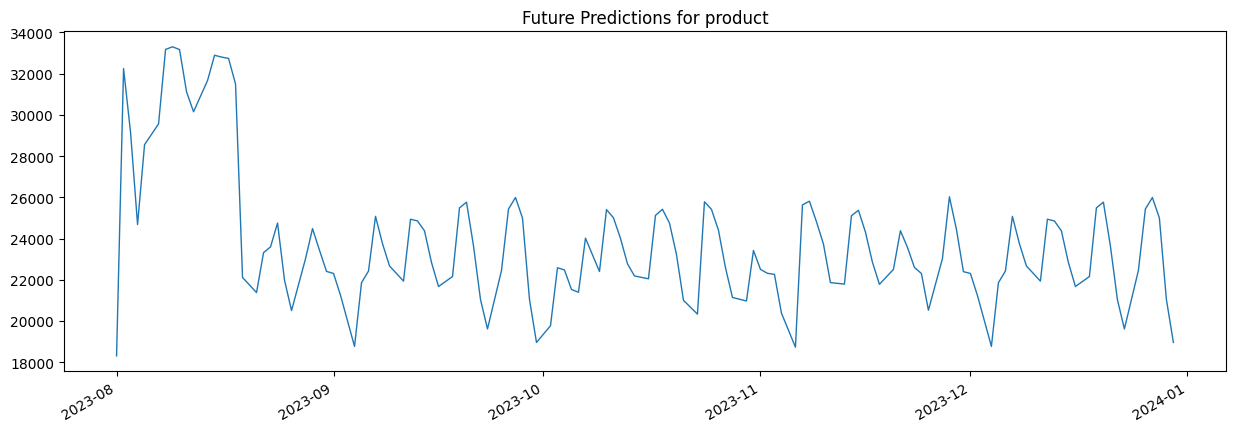

In [45]:
future_w_features['pred'].plot(figsize=(15, 5),
                               ms=1,
                               lw=1,
                               title='Future Predictions for product')
plt.show()

In [46]:
future_projections_monthly = future_w_features[['pred']]

In [47]:
future_projections_monthly.index = future_projections_monthly.index.to_period("M")

In [48]:
future_projections_monthly = future_projections_monthly.groupby(future_projections_monthly.index).sum()

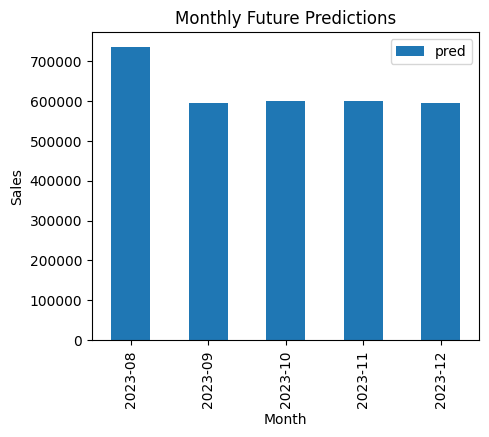

In [49]:
ax = future_projections_monthly.plot(
    kind='bar',
    figsize=(5, 4),
    title='Monthly Future Predictions'
)
ax.set_ylabel('Sales')  # Add label for y-axis
ax.set_xlabel('Month')  # Add label for x-axis

plt.show()

# Moddeling for complete data

Fetching relevant data

In [50]:
product_days_with_sales = dataset.groupby('product_name')['date'].nunique()

Removing insignificant data

In [51]:
products_with_enough_days = product_days_with_sales[product_days_with_sales >= 30].index

In [52]:
filtered_df = dataset[dataset['product_name'].isin(products_with_enough_days)]

In [53]:
df = filtered_df[['date','sale']]

In [54]:
df= df.groupby('date').sum().reset_index()

In [55]:
df = df.drop(df[df.date < '2023-01-01'].index)

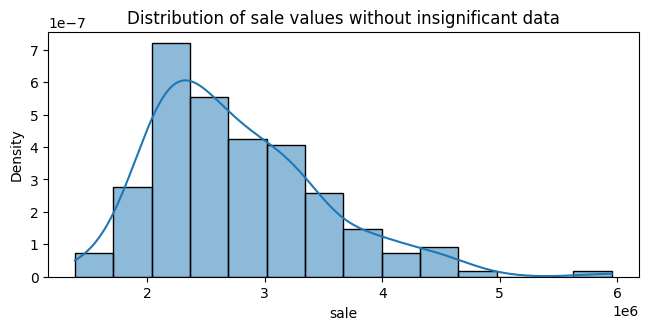

In [56]:
plt.figure(figsize=(16,7))
plt.subplot(2,2,1)
sns.histplot(df['sale'],kde=True,stat="density")
plt.title('Distribution of sale values without insignificant data')


plt.subplots_adjust(wspace=0.1)

Preparing data for feeding into model

In [57]:
unique_products = filtered_df['product_name'].unique()

In [58]:
all_forecasts_df = pd.DataFrame(index=pd.to_datetime([]))

Model prediction

In [59]:
for product_id in unique_products:
    df = dataset[dataset['product_name']==product_id]
    predict(df,product_id)

KeyboardInterrupt: 

In [ ]:
total_company_sales_daily = all_forecasts_df.groupby(all_forecasts_df.index)['forecasted_sales'].sum()

Visualisation of predicted data for the year

In [ ]:
ax = total_company_sales_daily.plot(figsize=(15, 5), legend=None)
ax.set_title('Total Company Sales Over Time', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
total_company_sales_monthly = all_forecasts_df[['forecasted_sales']]

In [ ]:
total_company_sales_monthly.index = total_company_sales_monthly.index.to_period("M")

In [ ]:
total_company_sales_monthly = total_company_sales_monthly.groupby(total_company_sales_monthly.index).sum()

In [ ]:
ax = total_company_sales_monthly.plot(
    kind='bar',
    figsize=(5, 4),
    title='Total Monthly Future Predictions'
)
ax.set_ylabel('Sales')  # Add label for y-axis
ax.set_xlabel('Month')  # Add label for x-axis

plt.show()